Problem Statement: 

The two subreddits I picked are **r/theonion** and **r/nottheonion**. 
Will my model be able to predict if a comment came from the onion or a real news source? 


I will be exploring a few different models to assess the accuracy.
I will create a Bayes classifier, Logistic Regression, and KNN (if there is enough time). 
Success will be evaluated by: 





- [Import data](#import)
- [Bag of words and visualizations](#vis)

<a id='import'></a>
# Import data

In [31]:
import requests
import json
import time
import csv
import pandas as pd
import sklearn
import numpy as np
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Scraping

I would have included the text of each title, but since all of the posts on both subreddits are just links to either Onion articles or real articles, there is no text accompanying these reddit posts.


Huge s/o to Remy Shea for sharing this code with me while mine refused to work past a certain number of calls. Thank you very much. 

In [2]:
def subreddit_scrape(subreddit_slug,num_hits=40):
    # Define a containing variable for posts and post names to aggregate into
    posts = []
    post_titles=[]
    after = None
    url = f'https://www.reddit.com/r/{subreddit_slug}.json'
    print(f'Collecting data from {url}')
    print('')

    # For loop to reach 1000 posts, since each request returns only 25 posts
    for i in range(num_hits):
        if i*100/num_hits%5 == 0:
            print(f'Progress: {round(i/num_hits * 100,1)}%') # Track progress

        # Initial loop does not have an 'after'
        if after == None:
            params={}
        else:
            params = {'after':after}

        # Hit the subreddit API, append the relevant data to containers
        res = requests.get(url,params=params,headers={'user-agent': 'Maithili'})
        if res.status_code==200:
            the_json = res.json()
            after = the_json['data']['after']
            if after == None:
                print(f"Done {i}")
                break
            else:
                posts.extend(the_json['data']['children'])
                post_titles.extend([post['data']['title'] for post in the_json['data']['children']])
        else:
            print(res.status_code)
            break
        # Wait a second, to not ping server too frequently
        time.sleep(1)
    
    # Report findings, return post list
    print('')
    print(f'Finished colleting data.')
    print(f'Of {len(post_titles)} titles, {len(set(post_titles))} were unique')
    return posts

In [3]:
the_onion = subreddit_scrape('TheOnion',num_hits=40)


Progress: 0.0%
Progress: 5.0%
Progress: 10.0%
Progress: 15.0%
Progress: 20.0%
Progress: 25.0%
Progress: 30.0%
Progress: 35.0%
Progress: 40.0%
Progress: 45.0%
Progress: 50.0%
Progress: 55.0%
Progress: 60.0%
Progress: 65.0%
Progress: 70.0%
Progress: 75.0%
Progress: 80.0%
Progress: 85.0%
Progress: 90.0%
Progress: 95.0%
Done 38

Finished colleting data.
Of 950 titles, 927 were unique


In [4]:
not_the_onion = subreddit_scrape('nottheonion',num_hits=40)


Progress: 0.0%
Progress: 5.0%
Progress: 10.0%
Progress: 15.0%
Progress: 20.0%
Progress: 25.0%
Progress: 30.0%
Progress: 35.0%
Progress: 40.0%
Done 17

Finished colleting data.
Of 425 titles, 406 were unique


I'm going to create a data frame and CSV so I don't lose all the data I looked at today. For the second day that I gather more posts, I'm going to create a new dataframe and concatenate it to my first dataframe.  

In [5]:
#not the onion
titles = [post['data']['title'] for post in not_the_onion]
subreddit = [post['data']['subreddit'] for post in not_the_onion]


#the onion
titles_onion = [post['data']['title'] for post in the_onion]
subreddit_onion = [post['data']['subreddit'] for post in the_onion]

In [6]:
#not the onion
Titles_not = pd.DataFrame(titles, columns = ['Titles'])
Subreddit_not = pd.DataFrame(subreddit, columns = ['Subreddit'])

#the onion
Titles_onion = pd.DataFrame(titles_onion, columns = ['Titles'])
Subreddit_onion = pd.DataFrame(subreddit_onion, columns = ['Subreddit'])

In [7]:
Not = pd.concat([Titles_not, Subreddit_not], axis = 1)

In [8]:
Not['Titles'][7]

'Man accidentally drowns while mowing his lawn'

<a id='vis'></a>
# Bag of words and visualizations

In [9]:
#bag of words for not the onion
train_corpus_no = Not['Titles']
test_corpus_no = Not['Subreddit']

# Instantiate a CountVectorizer
cvec_no = CountVectorizer(stop_words='english', ngram_range = (2,2))

# Fit the vectorizer on our corpus
cvec_no.fit(train_corpus_no)
#Set X_train
X_train_no = cvec_no.transform(train_corpus_no)
X_test_no = test_corpus_no

#CountVectorizer(ngram_range = (2,2)).fit(train_corpus).get_feature_names()

#Dataframe of bag of words at ngrams 2,2
X_train_cvec_no =pd.DataFrame(X_train_no.todense(), columns=cvec_no.get_feature_names())

In [38]:
no_words = X_train_cvec_no.sum(axis = 0)
word_list =no_words.sort_values(ascending = False).head(30)
#print(word_list)

In [21]:
word_count_notonion = pd.DataFrame(word_list).reset_index().rename(columns = {"index": 'word', 0: 'count'})

In [23]:
word_count_notonion.head()

,word,count
0,year old,11
1,police say,5
2,harry potter,4
3,pet fish,4
4,donald trump,4


In [11]:
Onion = pd.concat([Titles_onion, Subreddit_onion], axis = 1)

In [12]:
Onion['Titles'][30]

'The Onion Reviews ‘Pet Sematary’'

In [19]:
train_corpus_onion = Onion['Titles']
test_corpus_onion = Onion['Subreddit']

# Instantiate a CountVectorizer
cvec_onion = CountVectorizer(stop_words='english', ngram_range = (2,2))

# Fit the vectorizer on our corpus
cvec_onion.fit(train_corpus_no)
#Set X_train
X_train_onion = cvec_onion.transform(train_corpus_onion)
X_test_onion = test_corpus_onion

#CountVectorizer(ngram_range = (2,2)).fit(train_corpus).get_feature_names()

#Dataframe of bag of words at ngrams 2,2
X_train_cvec_onion =pd.DataFrame(X_train_onion.todense(), columns=cvec_onion.get_feature_names())

In [20]:
onion_words = X_train_cvec_onion.sum(axis = 0)
word_list_onion =onion_words.sort_values(ascending = False).head(30)
print(word_list_onion)

year old            14
super bowl          10
study finds          8
pope francis         5
introduces new       4
harry potter         4
12 year              3
fox news             3
20 years             3
high school          3
high speed           3
don know             3
supreme court        2
green new            2
old birthday         2
democratic party     2
school district      2
tucker carlson       2
donald trump         2
kim jong             1
giving birth         1
new deal             1
just asking          1
man gets             1
trump claims         1
wants know           1
elderly woman        1
social media         1
cruel unusual        1
married cousin       1
dtype: int64


In [27]:
word_count_onion = pd.DataFrame(word_list_onion).reset_index().rename(columns = {"index": 'word', 0: 'count'})

In [28]:
word_count_onion.head()

,word,count
0,year old,14
1,super bowl,10
2,study finds,8
3,pope francis,5
4,introduces new,4


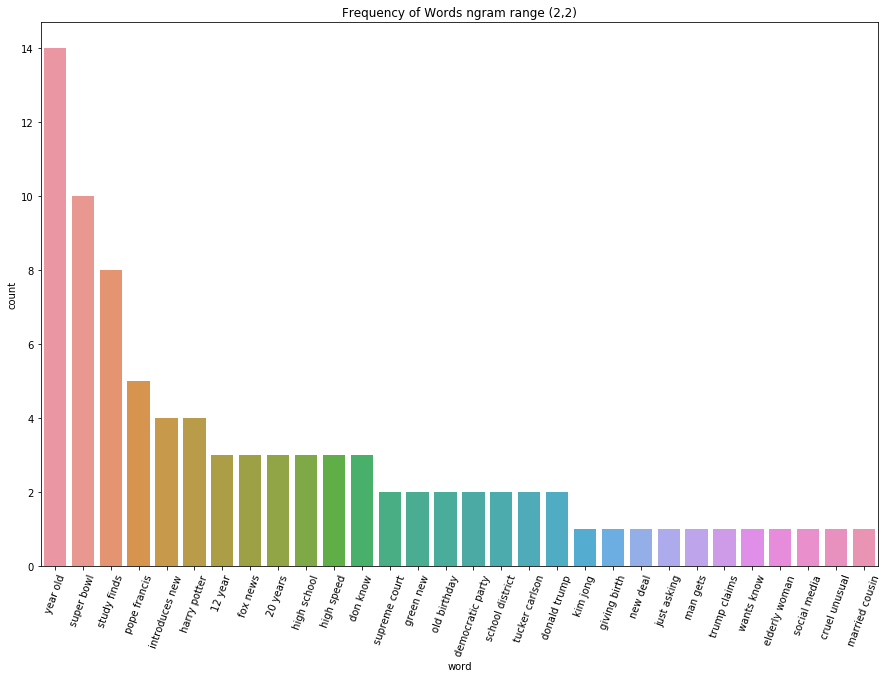

In [32]:
#bargraph of most used words in the onion
plt.figure(figsize=(15,10))
sns.barplot(x = 'word', y='count', data = word_count_onion)
plt.title('Frequency of Words ngram range (2,2)')
plt.xticks(rotation=70);

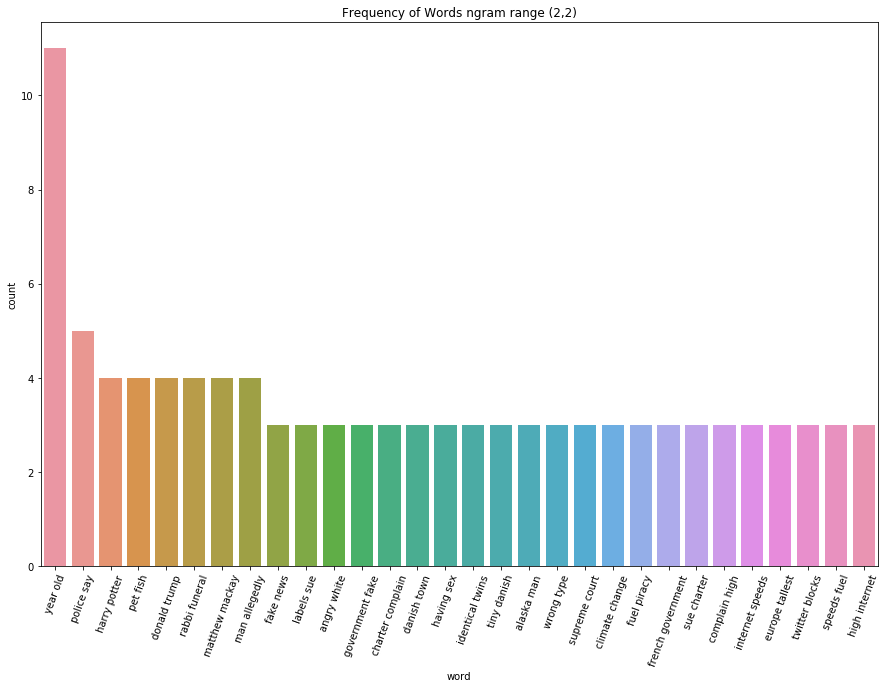

In [33]:
#bargraph of most used words in the onion
plt.figure(figsize=(15,10))
sns.barplot(x = 'word', y='count', data = word_count_notonion)
plt.title('Frequency of Words ngram range (2,2)')
plt.xticks(rotation=70);

In [15]:
reddit = pd.concat([Not, Onion], axis = 0)

In [16]:
reddit.head()

,Titles,Subreddit
0,Wife of El Chapo Having Trouble Trademarking H...,nottheonion
1,Canadian Family Stopped At Border After Drivin...,nottheonion
2,Zimbabwe spent thousands of dollars on judges'...,nottheonion
3,Motel 6 To Pay $12 Million After Improperly Gi...,nottheonion
4,Ex-Rep. Anthony Weiner ordered to register as ...,nottheonion


In [17]:
#reddit = reddit.to_csv('./scraped_data.csv')

In [37]:
reddit.shape

(1375, 2)